In [ ]:
!pip install pycountry
!pip install country_converter --upgrade
!pip install pycountry_convert

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pycountry
import country_converter as coco
import json, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # To visualize
from sklearn.linear_model import LinearRegression
pd.options.display.max_colwidth = 200
# Google Cloud services
gcp_service_account_credentials_json_filename = 'epfl-course-f41b0ed796f9.json' #need to upload the json credential files to the root directory of the google colab files
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = gcp_service_account_credentials_json_filename
credentials = service_account.Credentials.from_service_account_file(gcp_service_account_credentials_json_filename, scopes=['https://www.googleapis.com/auth/bigquery', 'https://www.googleapis.com/auth/drive'])
project_id = 'epfl-course'
bigquery_client = bigquery.Client(credentials=credentials, project=project_id)
bigquery_client = bigquery.Client()

# Execute a query on Google BigQuery (BQ)
def bq_execute_query(query, mode="INTERACTIVE", wait=False, to_dataframe=False):
    job_config = bigquery.QueryJobConfig(priority="bigquery.QueryPriority.{}".format(mode)) # Run at BATCH priority, which won't count toward concurrent rate limit, otherwise INTERACTIVE.
    query_job = bigquery_client.query(query, job_config)
    if wait==True:
        print("Executed BQ query: ", query_job.result())
    if to_dataframe==True:
        return(query_job.to_dataframe())
    else:
        return(query_job)

# Upload a Dataframe to BQ
def upload_df_to_bq(df, bq_destination_table, write_disposition="WRITE_APPEND"):
    #bq_table_name = "epfl-course.dataset.table"
    job_config = bigquery.LoadJobConfig(create_disposition="CREATE_IF_NEEDED", write_disposition=write_disposition) #write_disposition="WRITE_TRUNCATE" in order to delete all the data from old table and insert new data
    upload_df_to_bq_job = bigquery_client.load_table_from_dataframe(
        df, bq_destination_table, job_config = job_config)
    print("Uploaded DF to BQ: ",upload_df_to_bq_job.result()) 

# Upload of JSON file to BQ
def upload_json_to_bq(json_object, bq_table):
    try:
        job_config = bigquery.LoadJobConfig()
        job_config.autodetect = False #Change to True if the table on BQ does not exits
        job_config.max_bad_records = 0
        job_config.ignore_unknown_values = True
        job_config.source_format = 'NEWLINE_DELIMITED_JSON'
        job_config.create_disposition= "CREATE_IF_NEEDED"
        job_config.write_disposition= "WRITE_APPEND"
        job_config.schema_to_json(schema_table)
        job = bigquery_client.load_table_from_file(json_object, bq_table, job_config = job_config)
        print("Loaded JSON to BQ table {} as job {}".format(bq_table, job.result()))
        assert job.job_type == 'load'
        assert job.state == 'DONE'
    except:
        print("ERROR Could not load JSON to BQ table {} as job {}".format(bq_table, job.result()))

def disambiguate_country(code): 
    if pycountry.countries.get(alpha_2=code) : 
        return pycountry.countries.get(alpha_2=code).name + '(' + code + ')'
    return code

def get_continent(code):
  try:
    if pc.country_alpha3_to_country_alpha2(code):
      code_2 = pc.country_alpha3_to_country_alpha2(code)
      return pc.country_alpha2_to_continent_code(code_2)
  except Exception:
    pass
  return None



## Getting GDP
Here we get info aobut the gdp and population of different countries. 

Data was taken from the WorldBank website. We used the data as of 2018

In [ ]:
import pycountry_convert as pc

cc = coco.CountryConverter()
#import gdp_data
gdp = pd.read_csv('gdp_data_worldbank.csv', skiprows=4)
#select and rename columns
gdp = gdp[['Country Name','Country Code', '2018']]
gdp.columns = ['country', 'country_code', 'gdp_pc']

#import population data
population = pd.read_csv('population_data_worldbank.csv', skiprows=4)
#select and rename columns
population = population[['Country Name', '2018']]
population.columns = ['country', 'population']
#merge the datasets
gdp = pd.merge(gdp, population, how = 'left', left_on = 'country', right_on = 'country')
#rename the countries
gdp['country'] = gdp.apply(lambda x: disambiguate_country(cc.convert(names = x['country_code'], to = 'ISO2', not_found = 'None')), axis = 1)
gdp = gdp[gdp['country'] != 'None']
#compute total gdp
gdp['gdp_tot'] = gdp['population']*gdp['gdp_pc']
gdp['continent'] = gdp.apply(lambda x: get_continent(x['country_code']), axis = 1)

In [ ]:
gdp.head()

## GETTING Cooccurrences

Getting the cooccurrences of countries from the dataset on BQ. (Will retain only from US eventually)

In [ ]:
country_coocurrance_query = '''
WITH
country_coocurrance AS (
SELECT count(DISTINCT quoteid) as cnt, speaker_nationality, content_country FROM `epfl-course.ada_project.master_table` , 
UNNEST(speaker_nationalities) speaker_nationality, 
UNNEST(content_countries) content_country
WHERE main_topic_score > 0.5
GROUP BY speaker_nationality, content_country
),
speaker_country_coocurrance AS (
SELECT count(DISTINCT quoteid) as cnt, speaker_nationality FROM `epfl-course.ada_project.master_table` , 
UNNEST(speaker_nationalities) speaker_nationality
WHERE main_topic_score > 0.5
GROUP BY speaker_nationality
),
content_country_coocurrance AS (
SELECT count(DISTINCT quoteid) as cnt, content_country FROM `epfl-course.ada_project.master_table` , 
UNNEST(content_countries) content_country
WHERE main_topic_score > 0.5
GROUP BY content_country
),
num_articles AS (
    SELECT count(DISTINCT quoteid) as D FROM `epfl-course.ada_project.master_table`
    WHERE main_topic_score > 0.5
)
SELECT country_coocurrance.speaker_nationality, 
        country_coocurrance.content_country, 
        country_coocurrance.cnt as coocurrance,
        D as total_num_articles,
        ((country_coocurrance.cnt*D - speaker_country_coocurrance.cnt * content_country_coocurrance.cnt)/
        (sqrt(D*speaker_country_coocurrance.cnt - speaker_country_coocurrance.cnt*speaker_country_coocurrance.cnt)* 
        sqrt(D*content_country_coocurrance.cnt - content_country_coocurrance.cnt*content_country_coocurrance.cnt))) as correlation
    FROM ((country_coocurrance 
        INNER JOIN speaker_country_coocurrance  
        ON country_coocurrance.speaker_nationality = speaker_country_coocurrance.speaker_nationality)
        INNER JOIN content_country_coocurrance 
        ON country_coocurrance.content_country = content_country_coocurrance.content_country)
        CROSS JOIN num_articles 
    -- WHERE content_country_coocurrance.content_country != speaker_country_coocurrance.speaker_nationality
ORDER BY correlation DESC


'''
print(pycountry.countries.get(alpha_2='RU').name)
cooccurrence_df = bq_execute_query(country_coocurrance_query, to_dataframe = True)
cooccurrence_df['speaker_nationality'] = cooccurrence_df['speaker_nationality'].apply(disambiguate_country)
cooccurrence_df['content_country'] = cooccurrence_df['content_country'].apply(disambiguate_country)
cooccurrence_df.columns = ['speaker_nationality',	'content_country', 'cooccurrences',	'tot_num_articles',	'correlation']
cooccurrence_df.head()

## Getting data from us
Getting the quotes from speakers with american nationality

In [ ]:
sexy_query = """
SELECT 
  quoteId,
  quote_date,
  main_topic,
  main_topic_score,
  sub_unknown,
  sub_business_tech,
  sub_economy_market,
  sub_politics,
  sub_violence_cooperation,
  sub_legislation_law,
  sub_social_issues,
  sub_environments,
  content_countries,
  speaker_nationalities

FROM
  `epfl-course.ada_project.master_table`
WHERE
  DATE(LEFT(quoteid, 10)) between '2017-01-01' and '2020-12-31' AND 'US' IN UNNEST(speaker_nationalities)
"""
df = bq_execute_query(sexy_query, to_dataframe = True)
df.head()

## Prepare the data

In [ ]:
#generate unique set of countries inside content_countries field
content_countries = []
for idx, row in df.iterrows():
  content_countries += row['content_countries']
content_countries = set(content_countries)

#compute the one_hot_embedding for the topic
one_hot = pd.DataFrame(pd.get_dummies(df['main_topic']).values*df['main_topic_score'].values.reshape(-1, 1))
one_hot.columns = pd.get_dummies(df['main_topic']).columns
df = pd.merge(df, one_hot, left_index = True, right_index = True)
df.fillna(0, inplace = True)

#aggregate the data country-wise. 
#For a country we take all quotes from a speaker with that nationality
country_info = []
for c in content_countries:
  df['contains_country'] = df.apply(lambda x: c in x['content_countries'], axis = 1)
  temp = df[df['contains_country'] == True].mean()
  temp['country'] = disambiguate_country(c)
  country_info += [temp]
data = pd.DataFrame(country_info)
data.drop(columns = ['contains_country', 'main_topic_score'], inplace = True)
data.set_index(data['country'], inplace = True)
#drop the us to us quotes.
data.drop(disambiguate_country('US'), inplace = True)
data = data.drop(columns = 'country').reset_index()
data.head()

In [ ]:
#select only cooccurrences from US
from_us = cooccurrence_df[
              cooccurrence_df['speaker_nationality'] == 'United States(US)'].sort_values('cooccurrences', ascending = False ).copy()
#merge with gdp
merged = pd.merge(from_us, gdp, how = 'inner', left_on = 'content_country', right_on = 'country')
merged.drop(columns = ['speaker_nationality',
                       'tot_num_articles',
                       'correlation',
                       'country_code',],inplace = True
            )
merged.dropna(inplace = True)
merged = merged[merged['content_country'] != 'United States(US)']
data = pd.merge(left = data, right = merged, how = 'inner', left_on = 'country', right_on = 'country')
#naming continents
data['continent_names'] = data.continent.map({
    'AF':'Africa',
    'SA': 'Saudi Arabia',
    'AS': 'Asia',
    'EU': 'Europe',
    'NA':'North America',
    0:0,
    'OC':'OC'
})
#create one-hot embedding for continent
"""one_hot = pd.get_dummies(merged['continent'])
merged = pd.merge(merged, one_hot, left_index = True, right_index = True)
merged.drop(columns = 'continent', inplace = True)
"""
data.head(5)

In [ ]:
#push this data to BQ
table_id = "epfl-course.ada_project.cooccurring_countries"
bigquery_client = bigquery.Client(credentials=credentials, project=project_id)

job_config = bigquery.LoadJobConfig(
)

client = bigquery.Client()
job = client.load_table_from_dataframe(
    data, table_id, job_config=job_config
)  # Make an API request.
job.result()  # Wait for the job to complete.

table = client.get_table(table_id)  # Make an API request.
print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

## Continent-wise analysis

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


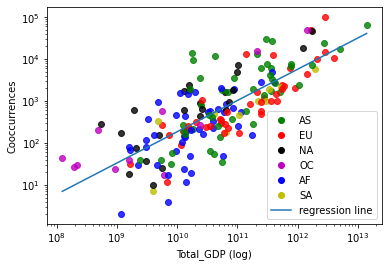

In [ ]:
#PLOT the overall trend gdp_tot vs cooccurrences
from numpy.core.numeric import NaN
import statsmodels.formula.api as smf
import statsmodels.api as sm
logged = data[['country', 'population', 'gdp_pc', 'gdp_tot', 'cooccurrences', 'continent']]
logged.dropna(inplace = True)
logged['col'] = logged.continent.map({
                            'AF':'b', 
                            'AS':'g',
                            'EU':'r',
                            'NA':'k',
                            'OC':'m',
                            'SA':'y',
})
fig, ax = plt.subplots()
for i, r in logged.iterrows():
    ax.plot(r['gdp_tot'], r['cooccurrences'], 'o',  color=r['col'], alpha = 0.8)
ax.plot(0, 0, 'o',  color='g', alpha = 1, label = 'AS')
ax.plot(0, 0, 'o',  color='r', alpha = 1, label = 'EU')
ax.plot(0, 0, 'o',  color='k', alpha = 1, label = 'NA')
ax.plot(0, 0, 'o',  color='m', alpha = 1, label = 'OC')
ax.plot(0, 0, 'o',  color='b', alpha = 1, label = 'AF')
ax.plot(0, 0, 'o',  color='y', alpha = 1, label = 'SA')

model = smf.ols('np.log(cooccurrences) ~ np.log(gdp_tot)', data=logged).fit()
x = np.linspace(np.min(logged.gdp_tot.values), np.max(logged.gdp_tot.values), 100)
plt.plot(x, np.exp(model.params['Intercept'])*x**model.params['np.log(gdp_tot)'], label = 'regression line')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total_GDP (log)')
plt.ylabel('Cooccurrences')
plt.legend()

In [ ]:
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     np.log(cooccurrences)   R-squared:                       0.589
Model:                               OLS   Adj. R-squared:                  0.586
Method:                    Least Squares   F-statistic:                     254.8
Date:                   Fri, 17 Dec 2021   Prob (F-statistic):           3.53e-36
Time:                           16:52:15   Log-Likelihood:                -309.14
No. Observations:                    180   AIC:                             622.3
Df Residuals:                        178   BIC:                             628.7
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept   

                              OLS Regression Results                             
Dep. Variable:     np.log(cooccurrences)   R-squared:                       0.741
Model:                               OLS   Adj. R-squared:                  0.734
Method:                    Least Squares   F-statistic:                     114.2
Date:                   Fri, 17 Dec 2021   Prob (F-statistic):           2.75e-13
Time:                           16:52:15   Log-Likelihood:                -57.295
No. Observations:                     42   AIC:                             118.6
Df Residuals:                         40   BIC:                             122.1
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept   

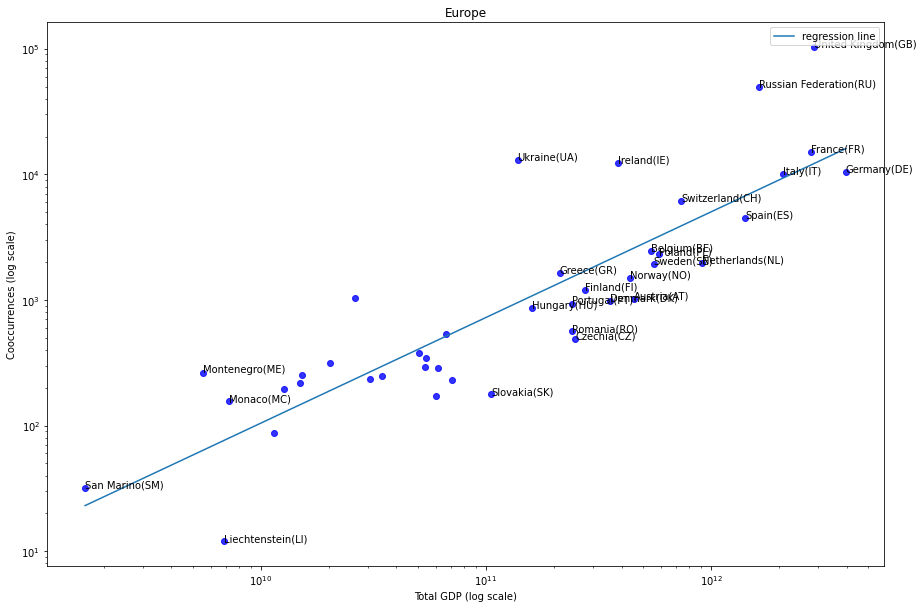

In [ ]:
#european country follow exactly a straight line
plt.figure(figsize = (15, 10))
european = logged[logged['continent'] == 'EU'].copy()
model = smf.ols('np.log(cooccurrences) ~ np.log(gdp_tot)', data=european).fit()
#print(model.summary())
for i, r in european.iterrows():
    plt.plot(r['gdp_tot'], r['cooccurrences'], 'o',  color='b', alpha = 0.8)
    if r['gdp_tot'] > 10**11 or  r['gdp_tot'] < 10**10:
      plt.text(r['gdp_tot'], r['cooccurrences'], r['country'])
x = np.linspace(np.min(european.gdp_tot.values), np.max(european.gdp_tot.values), 100)
plt.plot(x, np.exp(model.params['Intercept'])*x**model.params['np.log(gdp_tot)'], label = 'regression line')
plt.title('Europe')
plt.xlabel('Total GDP (log scale)')
plt.ylabel('Cooccurrences (log scale)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
print(model.summary())

Text(0.5, 1.0, 'European subtopic footprint_topics')

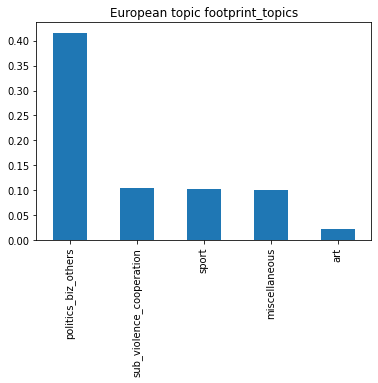

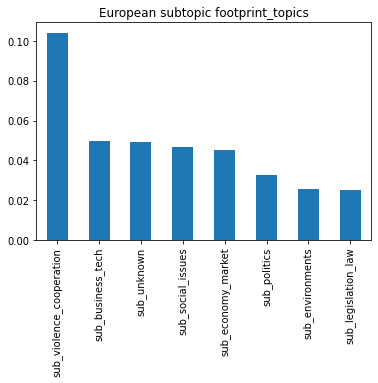

In [ ]:
#most important topics us -> european countries
main_topics = ['politics_biz_others', 'sport', 'sub_violence_cooperation', 'art', 'miscellaneous']
sub_topics = []
for i in data.columns:
  if i[:3] == 'sub':
    sub_topics += [i]

data.drop(columns = ['gdp_pc', 'gdp_tot', 'cooccurrences', 'population'])[data['continent'] == 'EU'][main_topics].mean().sort_values(ascending = False).plot.bar()
plt.title('European topic footprint_topics')

fig = plt.figure()
data.drop(columns = ['gdp_pc', 'gdp_tot', 'cooccurrences', 'population'])[data['continent'] == 'EU'][sub_topics].mean().sort_values(ascending = False).plot.bar()
plt.title('European subtopic footprint_topics')

                              OLS Regression Results                             
Dep. Variable:     np.log(cooccurrences)   R-squared:                       0.376
Model:                               OLS   Adj. R-squared:                  0.362
Method:                    Least Squares   F-statistic:                     26.55
Date:                   Fri, 17 Dec 2021   Prob (F-statistic):           5.81e-06
Time:                           16:52:19   Log-Likelihood:                -79.746
No. Observations:                     46   AIC:                             163.5
Df Residuals:                         44   BIC:                             167.1
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept   

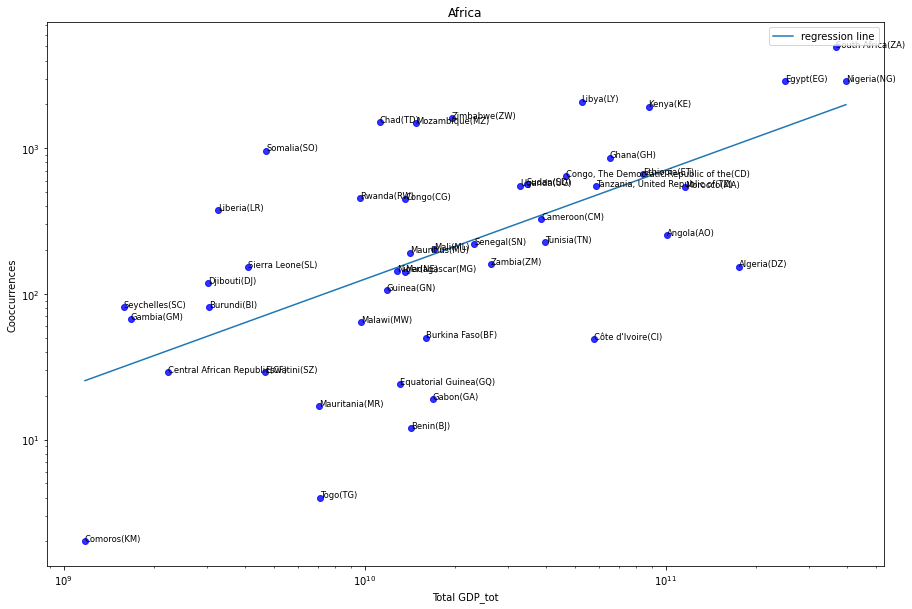

In [ ]:
plt.figure(figsize = (15, 10))
european = logged[logged['continent'] == 'AF'].copy()
for i, r in european.iterrows():
    plt.plot(r['gdp_tot'], r['cooccurrences'], 'o',  color=r['col'], alpha = 0.8)
    plt.text(r['gdp_tot'], r['cooccurrences'], r['country'], size='small')
plt.title('Africa')
plt.xlabel('Total GDP_tot')
plt.ylabel('Cooccurrences')
plt.xscale('log')
plt.yscale('log')
model = smf.ols('np.log(cooccurrences) ~ np.log(gdp_tot)', data=european).fit()
x = np.linspace(np.min(european.gdp_tot.values), np.max(european.gdp_tot.values), 100)
plt.plot(x, np.exp(model.params['Intercept'])*x**model.params['np.log(gdp_tot)'], label = 'regression line')
plt.legend()
print(model.summary())

Text(0.5, 1.0, 'African subtopic footprint_topics')

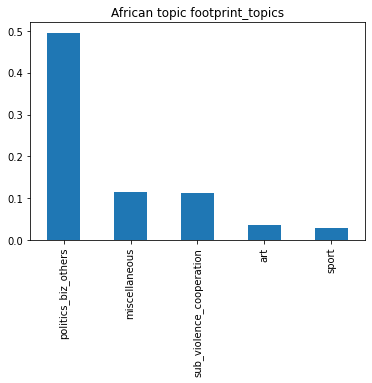

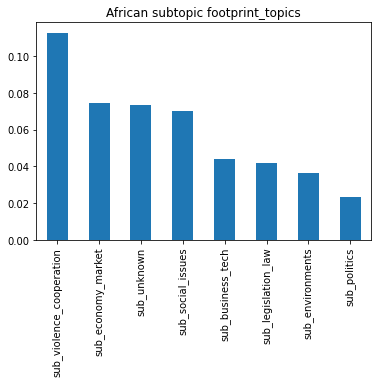

In [ ]:
data.drop(columns = ['gdp_pc', 'gdp_tot', 'cooccurrences', 'population'])[data['continent'] == 'AF'][main_topics].mean().sort_values(ascending = False).plot.bar()
plt.title('African topic footprint_topics')

fig = plt.figure()
data.drop(columns = ['gdp_pc', 'gdp_tot', 'cooccurrences', 'population'])[data['continent'] == 'AF'][sub_topics].mean().sort_values(ascending = False).plot.bar()
plt.title('African subtopic footprint_topics')

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


                              OLS Regression Results                             
Dep. Variable:     np.log(cooccurrences)   R-squared:                       0.733
Model:                               OLS   Adj. R-squared:                  0.700
Method:                    Least Squares   F-statistic:                     22.01
Date:                   Fri, 17 Dec 2021   Prob (F-statistic):            0.00156
Time:                           16:52:25   Log-Likelihood:                -13.126
No. Observations:                     10   AIC:                             30.25
Df Residuals:                          8   BIC:                             30.86
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept   

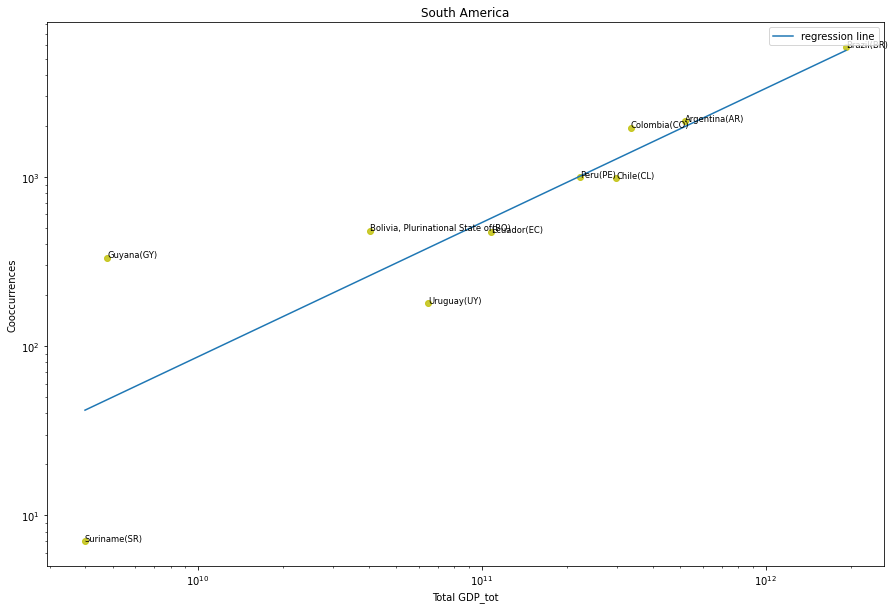

In [ ]:
plt.figure(figsize = (15, 10))
european = logged[logged['continent'] == 'SA'].copy()
for i, r in european.iterrows():
    plt.plot(r['gdp_tot'], r['cooccurrences'], 'o',  color=r['col'], alpha = 0.8)
    plt.text(r['gdp_tot'], r['cooccurrences'], r['country'], size='small')
plt.title('South America')
plt.xlabel('Total GDP_tot')
plt.ylabel('Cooccurrences')
plt.xscale('log')
plt.yscale('log')
model = smf.ols('np.log(cooccurrences) ~ np.log(gdp_tot)', data=european).fit()
x = np.linspace(np.min(european.gdp_tot.values), np.max(european.gdp_tot.values), 100)
plt.plot(x, np.exp(model.params['Intercept'])*x**model.params['np.log(gdp_tot)'], label = 'regression line')
plt.legend()
print(model.summary())

Text(0.5, 1.0, 'South America subtopic footprint_topics')

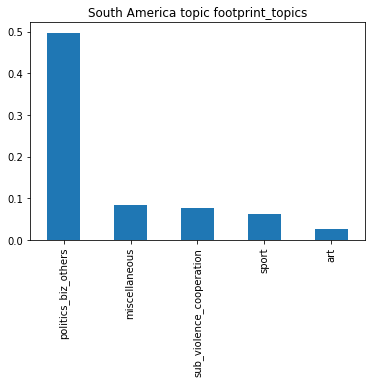

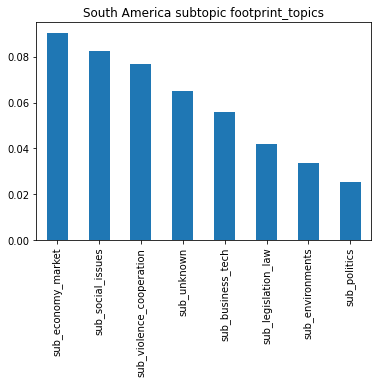

In [ ]:
data.drop(columns = ['gdp_pc', 'gdp_tot', 'cooccurrences', 'population'])[data['continent'] == 'SA'][main_topics].mean().sort_values(ascending = False).plot.bar()
plt.title('South America topic footprint_topics')

fig = plt.figure()
data.drop(columns = ['gdp_pc', 'gdp_tot', 'cooccurrences', 'population'])[data['continent'] == 'SA'][sub_topics].mean().sort_values(ascending = False).plot.bar()
plt.title('South America subtopic footprint_topics')

                              OLS Regression Results                             
Dep. Variable:     np.log(cooccurrences)   R-squared:                       0.502
Model:                               OLS   Adj. R-squared:                  0.491
Method:                    Least Squares   F-statistic:                     45.33
Date:                   Fri, 17 Dec 2021   Prob (F-statistic):           2.54e-08
Time:                           16:52:28   Log-Likelihood:                -84.415
No. Observations:                     47   AIC:                             172.8
Df Residuals:                         45   BIC:                             176.5
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept   

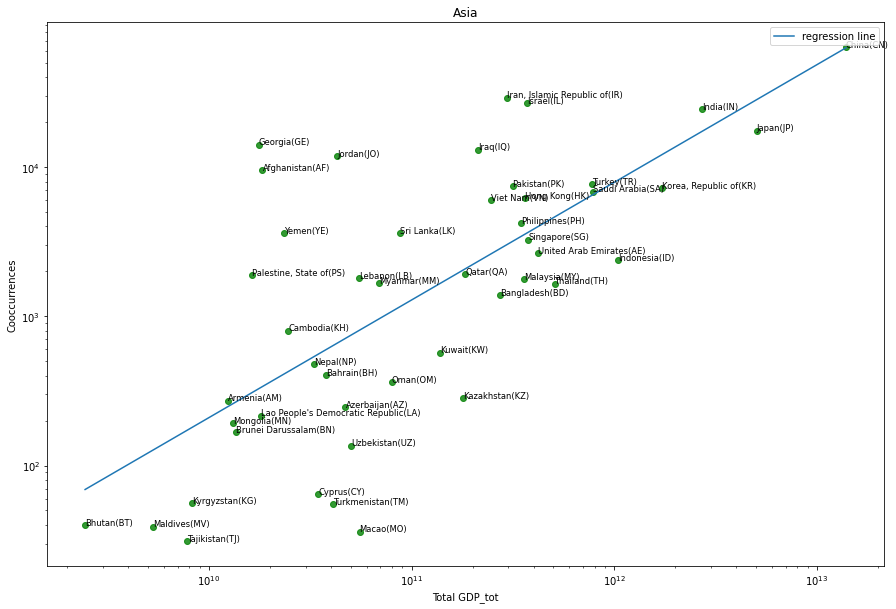

In [ ]:
plt.figure(figsize = (15, 10))
european = logged[logged['continent'] == 'AS'].copy()
for i, r in european.iterrows():
    plt.plot(r['gdp_tot'], r['cooccurrences'], 'o',  color=r['col'], alpha = 0.8)
    plt.text(r['gdp_tot'], r['cooccurrences'], r['country'], size='small')
plt.title('Asia')
plt.xlabel('Total GDP_tot')
plt.ylabel('Cooccurrences')
plt.xscale('log')
plt.yscale('log')
model = smf.ols('np.log(cooccurrences) ~ np.log(gdp_tot)', data=european).fit()
x = np.linspace(np.min(european.gdp_tot.values), np.max(european.gdp_tot.values), 100)
plt.plot(x, np.exp(model.params['Intercept'])*x**model.params['np.log(gdp_tot)'], label = 'regression line')
plt.legend()
print(model.summary())

Text(0.5, 1.0, 'Asian subtopic footprint_topics')

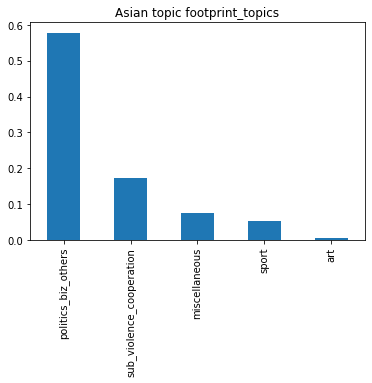

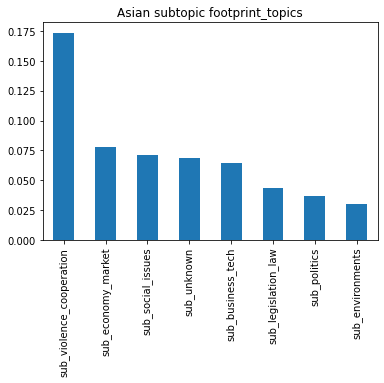

In [ ]:
data.drop(columns = ['gdp_pc', 'gdp_tot', 'cooccurrences', 'population'])[data['continent'] == 'AS'][main_topics].mean().sort_values(ascending = False).plot.bar()
plt.title('Asian topic footprint_topics')

fig = plt.figure()
data.drop(columns = ['gdp_pc', 'gdp_tot', 'cooccurrences', 'population'])[data['continent'] == 'AS'][sub_topics].mean().sort_values(ascending = False).plot.bar()
plt.title('Asian subtopic footprint_topics')

                              OLS Regression Results                             
Dep. Variable:     np.log(cooccurrences)   R-squared:                       0.657
Model:                               OLS   Adj. R-squared:                  0.642
Method:                    Least Squares   F-statistic:                     42.17
Date:                   Fri, 17 Dec 2021   Prob (F-statistic):           1.56e-06
Time:                           16:52:31   Log-Likelihood:                -38.729
No. Observations:                     24   AIC:                             81.46
Df Residuals:                         22   BIC:                             83.81
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept   

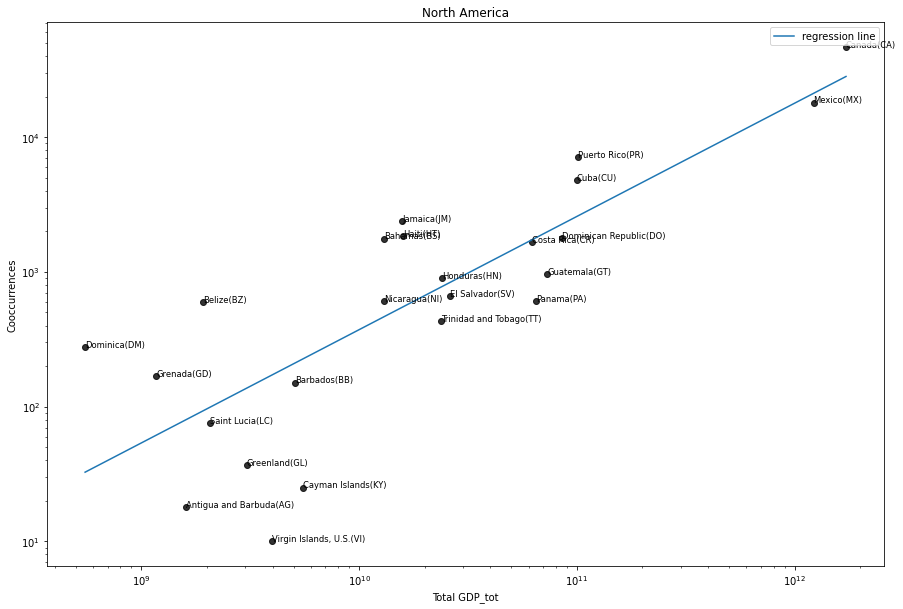

In [ ]:
plt.figure(figsize = (15, 10))
european = logged[logged['continent'] == 'NA'].copy()
for i, r in european.iterrows():
    plt.plot(r['gdp_tot'], r['cooccurrences'], 'o',  color=r['col'], alpha = 0.8)
    plt.text(r['gdp_tot'], r['cooccurrences'], r['country'], size='small')
plt.title('North America')
plt.xlabel('Total GDP_tot')
plt.ylabel('Cooccurrences')
plt.xscale('log')
plt.yscale('log')
model = smf.ols('np.log(cooccurrences) ~ np.log(gdp_tot)', data=european).fit()
x = np.linspace(np.min(european.gdp_tot.values), np.max(european.gdp_tot.values), 100)
plt.plot(x, np.exp(model.params['Intercept'])*x**model.params['np.log(gdp_tot)'], label = 'regression line')
plt.legend()
print(model.summary())

Text(0.5, 1.0, 'North American subtopic footprint_topics')

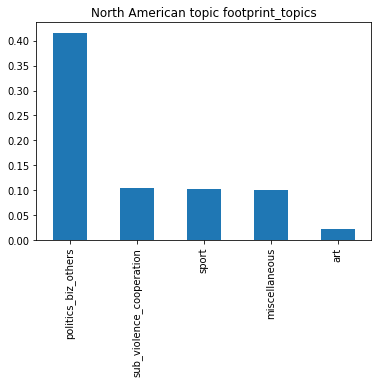

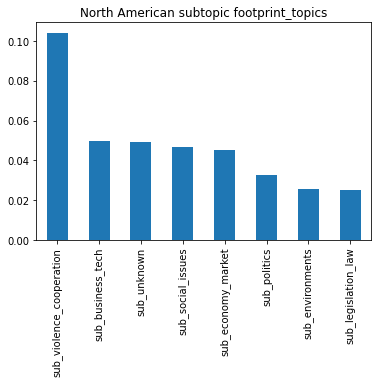

In [ ]:
data.drop(columns = ['gdp_pc', 'gdp_tot', 'cooccurrences', 'population'])[data['continent'] == 'EU'][main_topics].mean().sort_values(ascending = False).plot.bar()
plt.title('North American topic footprint_topics')

fig = plt.figure()
data.drop(columns = ['gdp_pc', 'gdp_tot', 'cooccurrences', 'population'])[data['continent'] == 'EU'][sub_topics].mean().sort_values(ascending = False).plot.bar()
plt.title('North American subtopic footprint_topics')

## Cooccurrences And Topic-Continent analysis

Text(0, 0.5, 'frequency count')

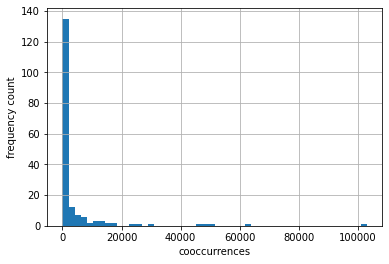

In [ ]:
#cooccurrences are distributed with a power low
data['cooccurrences'].hist(bins = 50)
plt.xlabel('cooccurrences')
plt.ylabel('frequency count')

In [ ]:
a = len(data[data['cooccurrences']>5000])/ len(data)
b = data[data['cooccurrences']>5000]['cooccurrences'].sum()/data['cooccurrences'].sum()
print(a)
print(b)
print('Cooccurrences follow a power distribution! This is showed by a back of the envelope calculation: ',round(100*a),'% of countries make up for ',round(100*b),'% of the cooccurrences')

0.16111111111111112
0.8344966856034817
Cooccurrences follow a power distribution! This is showed by a back of the envelope calculation:  16 % of countries make up for  83 % of the cooccurrences


Text(0, 0.5, 'Avg score for a given topic')

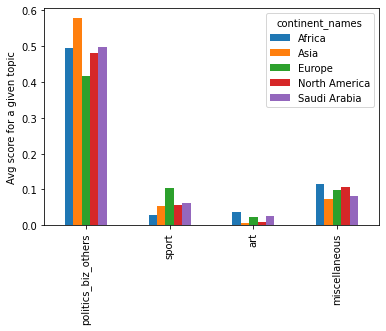

In [ ]:
#main_topic data aggregated continent-wise
data[main_topics + ['continent_names']].groupby(by = 'continent_names').mean().transpose().drop(columns = ['OC']).plot.bar()
plt.ylabel('Avg score for a given topic')

In [ ]:
#to BQ for visualization:
#push this data to BQ
table_id = "epfl-course.ada_project.main_topics_by_continent"
bigquery_client = bigquery.Client(credentials=credentials, project=project_id)

job_config = bigquery.LoadJobConfig(
)

client = bigquery.Client()
job = client.load_table_from_dataframe(
    data[main_topics + ['continent_names']].groupby(by = 'continent_names').mean(), table_id, job_config=job_config
)  # Make an API request.
job.result()  # Wait for the job to complete.

table = client.get_table(table_id)  # Make an API request.
print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

Loaded 12 rows and 5 columns to epfl-course.ada_project.main_topics_by_continent


Text(0, 0.5, 'Avg score for a given topic')

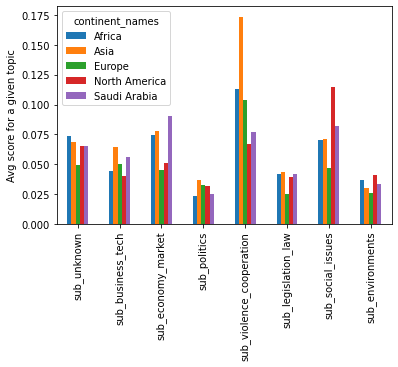

In [ ]:
#sub_topic data aggregated continent-wise
data[sub_topics + ['continent_names']].groupby(by = 'continent_names').mean().transpose().drop(columns = ['OC']).plot.bar()
plt.ylabel('Avg score for a given topic')

## Top Countries per topic

In [ ]:
#What are the coutry most associated with a given topic? 
for top in main_topics:
  print('\n\n #############################################################')
  print(top)
  for i, j in data[data['cooccurrences']>5000].sort_values(by = top, ascending = False)[[top, 'country', 'continent_names']].head(10).iterrows():
    print( j[top], '\t', j['continent_names'], '\t\t\t', j['country'],)



 #############################################################
politics_biz_others
0.7611448165360205 	 Asia 			 Iran, Islamic Republic of(IR)
0.7292403742826565 	 Asia 			 Saudi Arabia(SA)
0.701416469511314 	 Europe 			 Russian Federation(RU)
0.6919893093983837 	 Asia 			 China(CN)
0.691753096475443 	 Europe 			 Ukraine(UA)
0.6879721624827987 	 Asia 			 Iraq(IQ)
0.6635378292629349 	 Europe 			 Switzerland(CH)
0.6523644579470601 	 Asia 			 Turkey(TR)
0.6448079200890693 	 Asia 			 Israel(IL)
0.6311065960750358 	 Asia 			 Afghanistan(AF)


 #############################################################
sport
0.1642529987371885 	 Asia 			 Jordan(JO)
0.09811059892656121 	 Asia 			 Georgia(GE)
0.08599790234823484 	 Europe 			 Ireland(IE)
0.08119720430789647 	 North America 			 Canada(CA)
0.07853324581889681 	 OC 			 Australia(AU)
0.07828123754714114 	 Europe 			 Italy(IT)
0.07001058249262702 	 Europe 			 Germany(DE)
0.06649767601215689 	 Europe 			 France(FR)
0.06366662066061418 	 Europe 	

In [157]:
for top in sub_topics:
  print('\n\n #############################################################')
  print(top)
  for i, j in data[data['cooccurrences']>5000].sort_values(by = top, ascending = False)[[top, 'country', 'continent_names']].head(10).iterrows():
    print( j[top], '\t', j['continent_names'], '\t\t\t', j['country'],)



 #############################################################
sub_unknown
0.15603034275909303 	 OC 			 New Zealand(NZ)
0.08324743709780237 	 Europe 			 Italy(IT)
0.0817730625487904 	 OC 			 Australia(AU)
0.06516320598305919 	 Asia 			 Turkey(TR)
0.06356182213510335 	 Saudi Arabia 			 Brazil(BR)
0.0627148267460601 	 Asia 			 Saudi Arabia(SA)
0.062146304964916965 	 Asia 			 Hong Kong(HK)
0.062077614950938435 	 Europe 			 Ukraine(UA)
0.06189692400316044 	 Europe 			 Ireland(IE)
0.06119698266947815 	 Asia 			 Korea, Republic of(KR)


 #############################################################
sub_business_tech
0.25319606109075316 	 Europe 			 Switzerland(CH)
0.10596386553034527 	 Asia 			 India(IN)
0.08384060728918068 	 OC 			 New Zealand(NZ)
0.0734299322677595 	 Europe 			 United Kingdom(GB)
0.07169123509017439 	 Europe 			 Ireland(IE)
0.06922143475554486 	 Asia 			 China(CN)
0.06716725164623531 	 North America 			 Canada(CA)
0.0647078034408981 	 OC 			 Australia(AU)
0.0564188040433

In [ ]:
# distribution of the outliers